# Introducción

Este Notebook de Jupyter demuestra con un ejemplo práctico, la capacidad de los algoritmos de Deep Learning para clasificar imágenes de radiodiagnóstico médico. 

*El objetivo de este proyecto es entrenar a un algoritmo para que sea capaz de clasificar automáticamente una imágen de una radiografía de pecho en dos categorías (enferma vs no-enferma)*.
Acompañando a este Notebook encontrarás un post de contenido en el que explicamos, paso a paso, el recorrido a través del ejercicio práctico.

## Instalación y carga de dependencias

En esta sección instalamos y cargamos las librerías (los paquetes de R) que vamos a necesitar en este análisis. El paquete de R más representativo de este conjunto de dependencias es [Keras](https://keras.io/). En este [artículo](https://datos.gob.es/es/documentacion/tecnologias-emergentes-y-datos-abiertos-analitica-predictiva) ya comentamos sobre el uso de Keras como framework de Deep Learning.

(_La ejecución de este fragmento puede tardar unos minutos. Se paciente_)



In [ ]:
packages <- c("keras", "httr", "tidyverse", "reshape2", "patchwork")
package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE, quiet = TRUE)
      library(x, character.only = TRUE)
    }
  }
)


: 

<!-- Nota: si es la primera vez que ejecutas el notebook cambia la variable a TRUE (T) para instalar las dependencias. La primera ejecución tardará varios minutos en finalizar. -->



## Preparación del entorno de trabajo

### Configuración del motor de ejecución

Como hemos comentado en la introducción, este proyecto consiste en clasificar automáticamente imágenes de radiografía de pecho en dos categorías (enferma vs no-enferma). Un ejemplo del tipo de imágenes con las que vamos a trabajar es el siguiente.

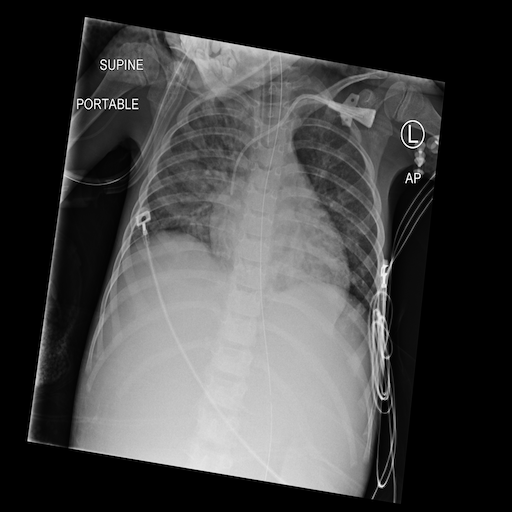

Antes de comenzar, deberíamos de establecer una configuración específica de nuestro runtime o entorno de ejecución. 

_En caso de que el usuario tenga la configuración para CPU que viene por defecto. En caso de que el usuario tenga ya establecida una configuración para GPU o TPU no es necesario realizar este paso_

El runtime es como el motor que va a ejecutar nuestro notebook. Para cambiar su configuración vamos a ir al menu superior de Google Colab y vamos a hacer click en `Runtime` o `Entorno de Ejecución`. Luego hacemos click en `change runtime type`. Vamos a seleccionar procesador de tipo GPU o TPU para que el entrenamiento de nuestro modelo se ejecute más rápido.

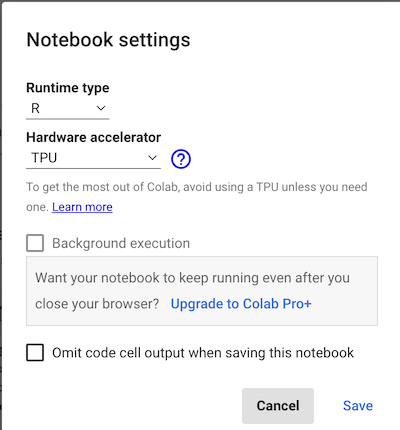



# Carga de datos (imagenes médicas)
Lo primero que vamos a hacer es crear un par de directorios de trabajo en nuestro espación temporal de Google Colab. En el menú izquierdo de la aplicación encontramos un icono con forma de carpeta. Haciendo click sobre él se nos expandirá un menú con nuestro arbol de directorios. 


In [2]:
#Creamos directorios locales
system("mkdir data")


Tras esta ejecución, aparecerá una carpeta adicional llamada data. En su interior las imágenes clasificadas en sus correspondientes carpetas.
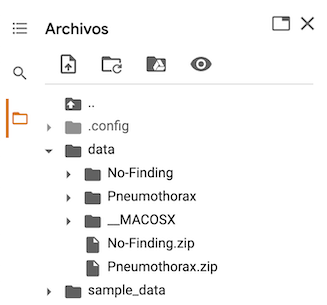

Los siguientes fragmentos de código (rutinas de código), se encargan de copiar en Google Colab las imágenes que vamos a utilizar para entrenar nuestro modelo. Las imágenes están ubicadas en un directorio remoto de Google Drive. Las operaciones que se realizan a continuación copiaran y descomprimirán las imágenes a procesar.

In [3]:
# downloading No-finding data
download.file('https://drive.google.com/uc?export=download&id=1enldo8iSt8lRiIBwsHD99zhbdqh-Bv4E&confirm=t&uuid=b34f162e-661c-45b7-967e-59639864b97b','./data/No-Finding.zip')

In [4]:
# unzipping No-Finding images
unzip("./data/No-Finding.zip", exdir = "./data/")


In [5]:
# downloading Pneumothorax data
download.file('https://drive.google.com/uc?export=download&id=1Do7L7JjdLaYiKUbyssYPFJxuIr4PE1Rn&confirm=t&uuid=9f8a18d6-98a2-49c7-ba6a-7c7f870832df','./data/Pneumothorax.zip')

In [6]:
# unzipping Pneumothorax images
unzip("./data/Pneumothorax.zip", exdir = "./data/")

# Comenzamos con el análisis

## Carga en memoria y pre-procesamiento.
Creamos una función que nos permite cargar en memoria todas las imágenes que previamente hemos copiado en el espacio de trabajo de Google Colab. Esta función nos ayuda a cargar masimavemente imágenes, además de hacer un pequeño pre-procesamiento como convertirlas a escala de grises y re-escalarlas todas a un tamaño de 100x100 pixeles.
_Nota: este fragmento de código define la función pero no la ejecuta. En la siguiente rutina es cuando se invoca la función_

In [ ]:
process_pix <- function(lsf) {
  img <- lapply(lsf, image_load, color_mode = "grayscale") # grayscale the image
  arr <- lapply(img, image_to_array) # turns it into an array
  arr_resized <- lapply(arr, image_array_resize, 
                        height = 100, 
                        width = 100) # resize
  arr_normalized <- normalize(arr_resized, axis = 1) #normalize to make small numbers 
  return(arr_normalized)
}


: 

Valiendonos de la función anterior, en este fragmento de código cargamos las imágenes desde de los directorios donde las hemos dejado previamente. Creamos dos conjuntos de imágenes (enfermedad vs no enfermedad) todas del mismo tamaño. Limitamos los conjuntos de imágenes a 500 para no sobrepasar la memoria de la máquina disponible en Google Colab para este análisis.



In [8]:
lsf <- list.files("./data/Pneumothorax", full.names = TRUE) 

lsf2 <- lsf[1:500]
dissease <- process_pix(lsf2)

dissease <- dissease[,,,1]
dissease_reshaped <- array_reshape(dissease, c(nrow(dissease), 100*100))

# Imágenes de personas SIN patologías
lsf3 <- list.files("./data/No-Finding", full.names = TRUE) 

lsf4 <- lsf3[1:500]

ndissease <- process_pix(lsf4)
ndissease  <- ndissease[,,,1]
ndissease_reshaped <- array_reshape(ndissease, c(nrow(ndissease), 100*100))


Loaded Tensorflow version 2.8.2



Tenemos 500 imágenes de rayos-x de personas con enfermedad y otras 500 imágenes de personas sin enfermedad.

# Visualización previa de los datos/imágenes

A continuación vemos un ejemplo de las imágenes que vamos a utilizar para entrenar el modelo. Obviamente, para un observador no experto no existen evidencias en las imágenes que nos permitan distinguir las características de una persona enferma de otra sana.


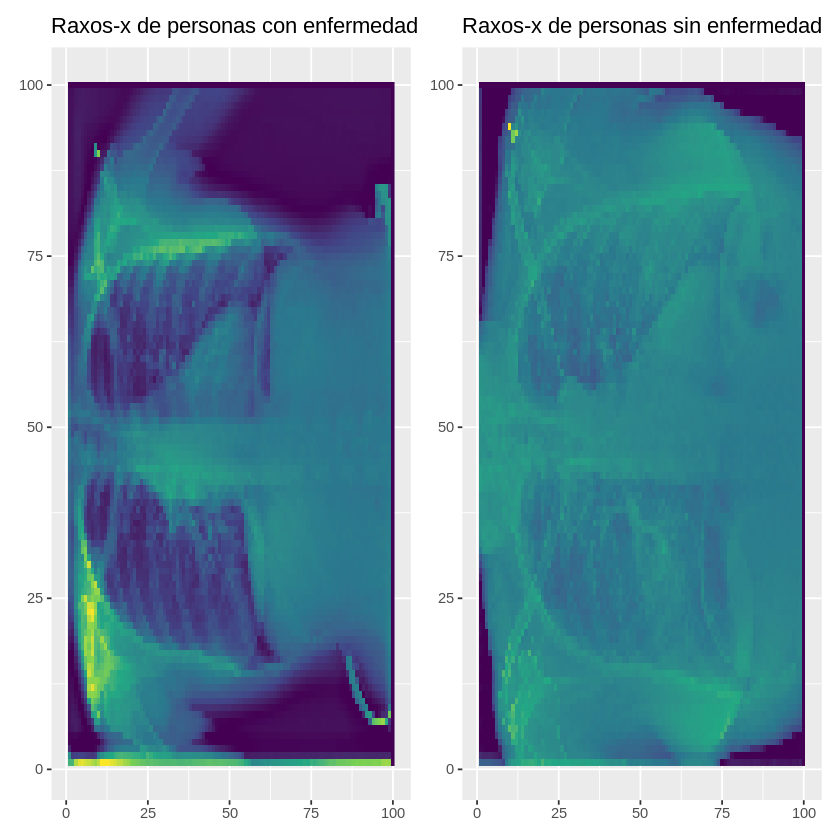

In [9]:
scandissease <- reshape2::melt(dissease[10,,])
plotdissease <- scandissease %>%
  ggplot() +
  aes(x = Var1, y = Var2, fill = value) + 
  geom_raster() +
  labs(x = NULL, y = NULL, title = "Raxos-x de personas con enfermedad") + 
  scale_fill_viridis_c() + 
  theme(legend.position = "none")

scanndissease <- reshape2::melt(ndissease[10,,])
plotndissease <- scanndissease %>%
  ggplot() +
  aes(x = Var1, y = Var2, fill = value) + 
  geom_raster() +
  labs(x = NULL, y = NULL, title = "Raxos-x de personas sin enfermedad") + 
  scale_fill_viridis_c() + 
  theme(legend.position = "none")


plotdissease + plotndissease


# Comenzamos la modelización. 

## Creación del conjunto de imágenes de entrenamiento.

Ahora vamos a mezclar de forma aleatoria, las imágenes de pacientes con enfermedad y sin ella. Así obtenemos una mezcla homogénea para entrenar el modelo.


In [10]:
df <- rbind(cbind(dissease_reshaped, 1), # 1 = dissease
            cbind(ndissease_reshaped, 0)) # 0 = no dissease
set.seed(1234)
shuffle <- sample(nrow(df), replace = F)
df <- df[shuffle, ]


## Creación de un set de entrenamiento/validación

La práctica habitual en el entrenamiento de modelos de clasificación es dividir el conjunto total de imágenes en dos conjuntos siguiendo la proporción (80%/20%). Es decir, vamos a entrenar el algoritmo con el 80% de las imágenes y validarlo con el 20% restante. El porcentaje se puede variar pero el 80/20 es la proporción habitual.


In [11]:
set.seed(2022)
split <- sample(2, nrow(df), replace = T, prob = c(0.8, 0.2))
train <- df[split == 1,]
test <- df[split == 2,]

train_target <- df[split == 1, 10001] # label in training dataset
test_target <- df[split == 2, 10001] # label in testing dataset

# Convertimos las etiquetas de enfermedad/no-enfermedad a un tipo de datos de tipo factor o categórico.

train_label <- to_categorical(train_target)
test_label <- to_categorical(test_target)

## Configuramos el modelo.

In [12]:
model <- keras_model_sequential() %>%
  layer_dense(units = 512, activation = "relu") %>% 
  layer_dropout(0.4) %>%
  layer_dense(units = 256, activation = "relu") %>%
  layer_dropout(0.3) %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dropout(0.2) %>%
  layer_dense(units = 2, activation = 'softmax')

In [13]:
model %>%
  compile(optimizer = 'adam',
          loss = 'binary_crossentropy', 
          metrics = c('accuracy'))

## Entrenamiento del modelo.

Una vez configurado nuestro modelo de redes neuronales, vamos a realizar el entrenamiento sobre el conjunto de imágenes. Como comentamos, se utiliza el 80% para entrenar y el 20% restante para validar los resultados.



In [19]:
set.seed(2022)
fit_dissease <- model %>%
  fit(x = train,
      y = train_label, 
      epochs = 120,
      batch_size = 512, # try also 256, 512
      verbose = 2,
      validation_split = 0.8)


Una visualización rápida sobre como se comporta el algoritmo sobre las imágenes que hemos reservado para validar.


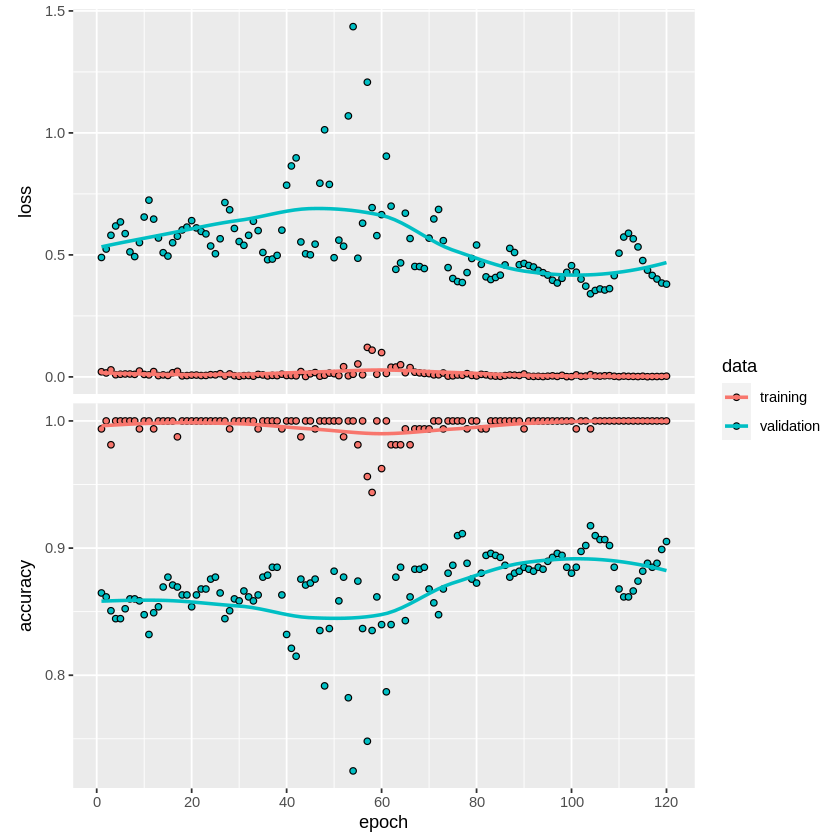

In [22]:
plot(fit_dissease)

Calculamos las métricas de rendimiento del algoritmo.



In [20]:
model %>%
  evaluate(test, test_label)


loss  accuracy 
0.4411619 0.9035533

Hacemos ahora algunas predicciones sobre imágenes de pacientes. Es decir, una vez entrenado y validado el algoritmo, nos preguntamos como va a clasificar las imágenes que le vamos a dar ahora. Como sabemos "la verdad" (lo que se denomina el ground truth) sobre las imágenes, comparamos el resultado de la predicción con la verdad. Para comprobar los resultados de la predicción (que variarán en función del número de imágenes que se usen en el entrenamiento) se utiliza lo que en ciencia de datos se denomina la matriz de confusión. La matriz de confusión:

-   coloca en la posición 1,1 los casos que SI tenían enfermedad y el modelo clasifica como "con enfermedad"
-   coloca en la posición 2,2, los casos que NO tenían enfermedad y el modelo clasifica como "sin enfermedad"

Es decir, estas son las posiciones en las que el modelo "acierta" en su clasificación.

En las posiciones contrarias, es decir, la 1,2 y la 2,1 son las posiciones en las que el modelo se "equivoca". Así, la 1,2 son los resultados que el modelo clasifica como CON enfermedad y la realidad es que eran pacientes sanos. La posición 2,1 justo lo contrario.


In [21]:
predictedclasses <- model %>%
  predict(test) %>% `>`(0.5) %>% k_cast("int32")
table(Prediction = as.numeric(predictedclasses[,2]), Truth = test_target)


          Truth
Prediction  0  1
         0 88 13
         1  6 90

# Conclusiones

Hemos entrenado un algoritmo de tipo CNN Convolutional neural network-CNN para realizar clasificaciones binarias (enfermo vs no-enfermo) sobre un conjunto de imágenes de rayos-x de pecho tanto de pacientes sanos como de pacientes con varias patologías. Por sencillez, hemos escogido pacientes sanos y pacientes que presentan un Pneumothorax previamente identificado por un médico. El resultado del entrenamiento nos ofrece un algoritmo de clasificación robusto para el screening automático. En [este post](https://datos.gob.es) complementario te explicamos las claves de este ejercicio con más detalle.
